In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

import re
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import adam_v2

import os

print("Imports complete!!!")

Imports complete!!!


[nltk_data] Downloading package punkt to /Users/lucasderr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasderr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
dataset = pd.read_csv('play_by_play_2021.csv')
print(dataset.shape)
print(dataset.head(3))

/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50536, 372)
   play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
1       40  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
2       55  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     1   
1     1     TEN         home     ARI  ...             0                     1   
2     1     TEN         home     ARI  ...             0                     1   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1  0.000000       NaN                NaN                  NaN          NaN   
2 -1.399805       NaN                NaN                  NaN          NaN   

   xyac_fd     xpass    pass_oe  
0      NaN

In [4]:
all_titles = ["play_id","game_id","old_game_id","home_team","away_team","season_type","week","posteam","posteam_type","defteam","side_of_field","yardline_100","game_date","quarter_seconds_remaining","half_seconds_remaining","game_seconds_remaining","game_half","quarter_end","drive","sp","qtr","down","goal_to_go","time","yrdln","ydstogo","ydsnet","desc","play_type","yards_gained","shotgun","no_huddle","qb_dropback","qb_kneel","qb_spike","qb_scramble","pass_length","pass_location","air_yards","yards_after_catch","run_location","run_gap","field_goal_result","kick_distance","extra_point_result","two_point_conv_result","home_timeouts_remaining","away_timeouts_remaining","timeout","timeout_team","td_team","td_player_name","td_player_id","posteam_timeouts_remaining","defteam_timeouts_remaining","total_home_score","total_away_score","posteam_score","defteam_score","score_differential","posteam_score_post","defteam_score_post","score_differential_post","no_score_prob","opp_fg_prob","opp_safety_prob","opp_td_prob","fg_prob","safety_prob","td_prob","extra_point_prob","two_point_conversion_prob","ep","epa","total_home_epa","total_away_epa","total_home_rush_epa","total_away_rush_epa","total_home_pass_epa","total_away_pass_epa","air_epa","yac_epa","comp_air_epa","comp_yac_epa","total_home_comp_air_epa","total_away_comp_air_epa","total_home_comp_yac_epa","total_away_comp_yac_epa","total_home_raw_air_epa","total_away_raw_air_epa","total_home_raw_yac_epa","total_away_raw_yac_epa","wp","def_wp","home_wp","away_wp","wpa","vegas_wpa","vegas_home_wpa","home_wp_post","away_wp_post","vegas_wp","vegas_home_wp","total_home_rush_wpa","total_away_rush_wpa","total_home_pass_wpa","total_away_pass_wpa","air_wpa","yac_wpa","comp_air_wpa","comp_yac_wpa","total_home_comp_air_wpa","total_away_comp_air_wpa","total_home_comp_yac_wpa","total_away_comp_yac_wpa","total_home_raw_air_wpa","total_away_raw_air_wpa","total_home_raw_yac_wpa","total_away_raw_yac_wpa","punt_blocked","first_down_rush","first_down_pass","first_down_penalty","third_down_converted","third_down_failed","fourth_down_converted","fourth_down_failed","incomplete_pass","touchback","interception","punt_inside_twenty","punt_in_endzone","punt_out_of_bounds","punt_downed","punt_fair_catch","kickoff_inside_twenty","kickoff_in_endzone","kickoff_out_of_bounds","kickoff_downed","kickoff_fair_catch","fumble_forced","fumble_not_forced","fumble_out_of_bounds","solo_tackle","safety","penalty","tackled_for_loss","fumble_lost","own_kickoff_recovery","own_kickoff_recovery_td","qb_hit","rush_attempt","pass_attempt","sack","touchdown","pass_touchdown","rush_touchdown","return_touchdown","extra_point_attempt","two_point_attempt","field_goal_attempt","kickoff_attempt","punt_attempt","fumble","complete_pass","assist_tackle","lateral_reception","lateral_rush","lateral_return","lateral_recovery","passer_player_id","passer_player_name","passing_yards","receiver_player_id","receiver_player_name","receiving_yards","rusher_player_id","rusher_player_name","rushing_yards","lateral_receiver_player_id","lateral_receiver_player_name","lateral_receiving_yards","lateral_rusher_player_id","lateral_rusher_player_name","lateral_rushing_yards","lateral_sack_player_id","lateral_sack_player_name","interception_player_id","interception_player_name","lateral_interception_player_id","lateral_interception_player_name","punt_returner_player_id","punt_returner_player_name","lateral_punt_returner_player_id","lateral_punt_returner_player_name","kickoff_returner_player_name","kickoff_returner_player_id","lateral_kickoff_returner_player_id","lateral_kickoff_returner_player_name","punter_player_id","punter_player_name","kicker_player_name","kicker_player_id","own_kickoff_recovery_player_id","own_kickoff_recovery_player_name","blocked_player_id","blocked_player_name","tackle_for_loss_1_player_id","tackle_for_loss_1_player_name","tackle_for_loss_2_player_id","tackle_for_loss_2_player_name","qb_hit_1_player_id","qb_hit_1_player_name","qb_hit_2_player_id","qb_hit_2_player_name","forced_fumble_player_1_team","forced_fumble_player_1_player_id","forced_fumble_player_1_player_name","forced_fumble_player_2_team","forced_fumble_player_2_player_id","forced_fumble_player_2_player_name","solo_tackle_1_team","solo_tackle_2_team","solo_tackle_1_player_id","solo_tackle_2_player_id","solo_tackle_1_player_name","solo_tackle_2_player_name","assist_tackle_1_player_id","assist_tackle_1_player_name","assist_tackle_1_team","assist_tackle_2_player_id","assist_tackle_2_player_name","assist_tackle_2_team","assist_tackle_3_player_id","assist_tackle_3_player_name","assist_tackle_3_team","assist_tackle_4_player_id","assist_tackle_4_player_name","assist_tackle_4_team","tackle_with_assist","tackle_with_assist_1_player_id","tackle_with_assist_1_player_name","tackle_with_assist_1_team","tackle_with_assist_2_player_id","tackle_with_assist_2_player_name","tackle_with_assist_2_team","pass_defense_1_player_id","pass_defense_1_player_name","pass_defense_2_player_id","pass_defense_2_player_name","fumbled_1_team","fumbled_1_player_id","fumbled_1_player_name","fumbled_2_player_id","fumbled_2_player_name","fumbled_2_team","fumble_recovery_1_team","fumble_recovery_1_yards","fumble_recovery_1_player_id","fumble_recovery_1_player_name","fumble_recovery_2_team","fumble_recovery_2_yards","fumble_recovery_2_player_id","fumble_recovery_2_player_name","sack_player_id","sack_player_name","half_sack_1_player_id","half_sack_1_player_name","half_sack_2_player_id","half_sack_2_player_name","return_team","return_yards","penalty_team","penalty_player_id","penalty_player_name","penalty_yards","replay_or_challenge","replay_or_challenge_result","penalty_type","defensive_two_point_attempt","defensive_two_point_conv","defensive_extra_point_attempt","defensive_extra_point_conv","safety_player_name","safety_player_id","season","cp","cpoe","series","series_success","series_result","order_sequence","start_time","time_of_day","stadium","weather","nfl_api_id","play_clock","play_deleted","play_type_nfl","special_teams_play","st_play_type","end_clock_time","end_yard_line","fixed_drive","fixed_drive_result","drive_real_start_time","drive_play_count","drive_time_of_possession","drive_first_downs","drive_inside20","drive_ended_with_score","drive_quarter_start","drive_quarter_end","drive_yards_penalized","drive_start_transition","drive_end_transition","drive_game_clock_start","drive_game_clock_end","drive_start_yard_line","drive_end_yard_line","drive_play_id_started","drive_play_id_ended","away_score","home_score","location","result","total","spread_line","total_line","div_game","roof","surface","temp","wind","home_coach","away_coach","stadium_id","game_stadium","aborted_play","success","passer","passer_jersey_number","rusher","rusher_jersey_number","receiver","receiver_jersey_number","pass","rush","first_down","special","play","passer_id","rusher_id","receiver_id","name","jersey_number","id","fantasy_player_name","fantasy_player_id","fantasy","fantasy_id","out_of_bounds","home_opening_kickoff","qb_epa","xyac_epa","xyac_mean_yardage","xyac_median_yardage","xyac_success","xyac_fd","xpass","pass_oe"]
important_titles = ["play_id",
                    "game_id", #Unique Game Id
                    "posteam", #Offence/Possetion Team
                    "result",
                    "posteam_type", #Offence Home/Away
                    "defteam", #Defence Team
                    "yardline_100", #Yards from Touchdown
                    "half_seconds_remaining",
                    "game_half",
                    "drive", #Number of Posetions
                    "down",
                    "goal_to_go", #is it 4th and goal? 0 if no, 1 if yes
                    "time",
                    "ydstogo", #yards till first down/touchdown
                    "desc", #description
                    "play_type",
                    "yards_gained", #0 if punted or field goal
                    "qb_kneel", #rare 4th down occurance but possible
                    "field_goal_result",
                    "kick_distance",
                    "posteam_timeouts_remaining",
                    "defteam_timeouts_remaining",
                    "total_home_score",
                    "total_away_score",
                    "posteam_score",
                    "defteam_score",
                    "score_differential",
                    "score_differential_post", #score differential after play happened
                    "no_score_prob",
                    "opp_fg_prob",
                    "opp_safety_prob",
                    "opp_td_prob",
                    "fg_prob",
                    "safety_prob",
                    "td_prob",
                    "wp", #winning percentage
                    "def_wp", 
                    "home_wp_post",
                    "away_wp_post",
                    "punt_blocked",
                    "third_down_converted",
                    "third_down_failed",
                    "fourth_down_converted",
                    "fourth_down_failed",
                    "punt_inside_twenty",
                    "punt_in_endzone",
                    "punt_out_of_bounds",
                    "punt_downed",
                    "punt_fair_catch",
                    "season", #2021 for now
                    "series_result",
                    "weather",
                    "nfl_api_id", #new data set-ish
                    "play_type_nfl",
                    "special_teams_play", #0 or 1
                    "drive_play_count",
                    "drive_time_of_possession",
                    "drive_first_downs",
                    "drive_inside20",
                    "drive_ended_with_score",
                    "roof",
                    "surface",
                    "wind" #no valuable info could add from weather
                   ]

dataset = dataset[important_titles]

                    
game_winners = {}
for x in dataset['game_id'].unique():
    temp = dataset.copy()
    temp = temp[(temp['game_id'] == x) & (temp['desc'] == "END GAME")]
    if (temp['total_home_score'] > temp["total_away_score"]).bool():
        game_winners[x] = "home"
    elif (temp['total_home_score'] < temp["total_away_score"]).bool():
        game_winners[x] = "away"
    else:
        game_winners[x] = "TIE"
    
                    
def f(row):
    game_id = row['game_id']
    winner = game_winners[game_id]
    if row['posteam_type'] == winner:
        return 1
    else:
        return 0

dataset['Won'] = dataset.apply(f, axis=1) #TIE CONSIDERED 0


print(dataset.head(3))

   play_id          game_id posteam  result posteam_type defteam  \
0        1  2021_01_ARI_TEN     NaN     -25          NaN     NaN   
1       40  2021_01_ARI_TEN     TEN     -25         home     ARI   
2       55  2021_01_ARI_TEN     TEN     -25         home     ARI   

   yardline_100  half_seconds_remaining game_half  drive  ...  \
0           NaN                  1800.0     Half1    NaN  ...   
1          35.0                  1800.0     Half1    1.0  ...   
2          75.0                  1800.0     Half1    1.0  ...   

   special_teams_play  drive_play_count drive_time_of_possession  \
0                   0               NaN                      NaN   
1                   1               3.0                     1:33   
2                   0               3.0                     1:33   

   drive_first_downs drive_inside20 drive_ended_with_score      roof  surface  \
0                NaN            NaN                    NaN  outdoors    grass   
1                0.0           

In [5]:
dataset = pd.read_csv('play_by_play_2021.csv')
print(dataset.shape)
print(dataset.head(3))

/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(50536, 372)
   play_id          game_id  old_game_id home_team away_team season_type  \
0        1  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
1       40  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   
2       55  2021_01_ARI_TEN   2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0     1     NaN          NaN     NaN  ...             0                     1   
1     1     TEN         home     ARI  ...             0                     1   
2     1     TEN         home     ARI  ...             0                     1   

     qb_epa  xyac_epa  xyac_mean_yardage  xyac_median_yardage xyac_success  \
0       NaN       NaN                NaN                  NaN          NaN   
1  0.000000       NaN                NaN                  NaN          NaN   
2 -1.399805       NaN                NaN                  NaN          NaN   

   xyac_fd     xpass    pass_oe  
0      NaN

In [6]:
fourthdown = dataset[dataset['down']==4]
print(fourthdown.shape)

(4235, 372)


(4235,)


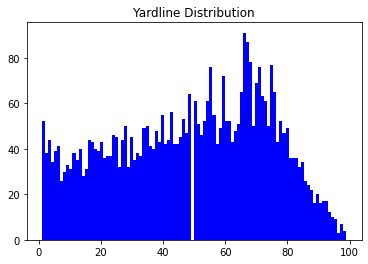

In [7]:
yardline = fourthdown['yardline_100']
print(yardline.shape)

plt.hist(yardline,color='blue', bins = 100)
plt.title('Yardline Distribution')
plt.show()

/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Play Types')]

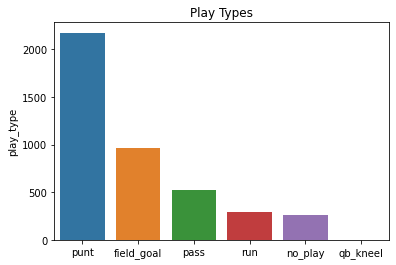

In [8]:
x = fourthdown.play_type.value_counts()
sns.barplot(x.index, x,).set(title="Play Types")



In [9]:
# result feature gives final score 
# negative score in favor of away team, positive score in favor of home team
# how do we classify a tie?

# won = fourthdown[(fourthdown['posteam_type'] == 'home' & fourthdown['result'] > 0) | (fourthdown['posteam_type'] == 'away' & fourthdown['result'] < 0)]
def who_won(row):
    row = row.to_numpy()
    if((row[0] == 'home' and row[1] > 0) or (row[0] == 'away' and row[1] < 0)):
        return 1
    elif(row[1] == 0): return 2 # use 2 for a tie
    else: return 0

labels = fourthdown[['posteam_type', 'result']].apply(who_won, axis=1)
fourthdown['labels'] = labels
print(fourthdown['labels'])

5        0
16       1
31       0
35       1
39       0
        ..
50497    0
50498    0
50507    1
50513    0
50526    1
Name: labels, Length: 4235, dtype: int64


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_89892/851947345.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['labels'] = labels


In [10]:
won = fourthdown[fourthdown['labels'] == 1]
lost = fourthdown[fourthdown['labels'] == 0]

/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Label Counts')]

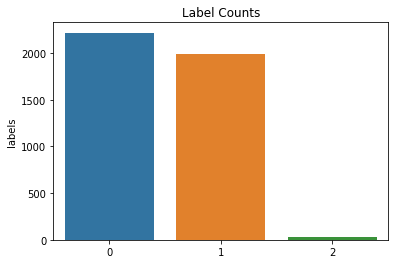

In [11]:
x = fourthdown.labels.value_counts()
sns.barplot(x.index, x,).set(title="Label Counts")

(-1.1098309613090545,
 1.1004681438464667,
 -1.1139321421635187,
 1.1083298430121105)

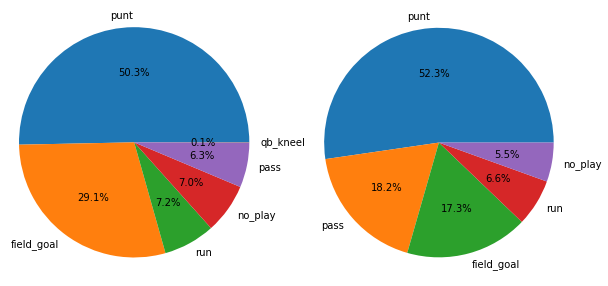

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

a = won.play_type.value_counts()
b = lost.play_type.value_counts()


ax1.pie(a,  labels=a.index,autopct='%1.1f%%')
ax1.axis('equal')

ax2.pie(b,  labels=b.index,autopct='%1.1f%%')
ax2.axis('equal')



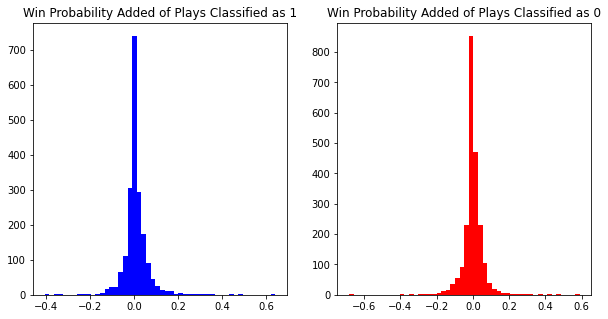

Teams that Won: 
Mean: 0.00770836548121399
Standard Deviation: 0.05828831294287519
Teams that Lost: 
Mean: 0.0007522205959276271
Standard Deviation: 0.059738546095157385


In [13]:
# plays that are not punts or field goals 


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
wpa = won['wpa']
wpa_mean, wpa_std = wpa.mean(), wpa.std()
ax1.hist(wpa,color='blue',bins=50)
ax1.set_title('Win Probability Added of Plays Classified as 1')

wpa_ = lost['wpa']
wpa__mean, wpa__std = wpa_.mean(), wpa_.std()
ax2.hist(wpa_, color='red',bins=50)
ax2.set_title('Win Probability Added of Plays Classified as 0')
plt.show()

print("Teams that Won: ")
print("Mean: " + str(wpa_mean))
print("Standard Deviation: " + str(wpa_std))

print("Teams that Lost: ")
print("Mean: " + str(wpa__mean))
print("Standard Deviation: " + str(wpa__std))



In [14]:
# wpa = win probability added
# The average wpa is just the (wpa + vegas_wpa) / 2
# The idea is to take the absolute value of the average wpa and have that be the weights
avg_wpa = fourthdown[['wpa', 'vegas_wpa']].apply(lambda x: (x[0] + x[1]) / 2, axis=1)
fourthdown['avg_wpa'] = avg_wpa


weights = fourthdown['avg_wpa'].apply(lambda x: abs(x))
fourthdown['weights'] = weights


print(fourthdown['avg_wpa'])
print("esketit")
print(fourthdown['weights'])

5        0.006982
16       0.024919
31       0.025890
35      -0.004165
39       0.059296
           ...   
50497   -0.031514
50498   -0.019756
50507    0.022418
50513    0.046366
50526    0.022052
Name: avg_wpa, Length: 4235, dtype: float64
esketit
5        0.006982
16       0.024919
31       0.025890
35       0.004165
39       0.059296
           ...   
50497    0.031514
50498    0.019756
50507    0.022418
50513    0.046366
50526    0.022052
Name: weights, Length: 4235, dtype: float64


/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_89892/1161158257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['avg_wpa'] = avg_wpa
/var/folders/bh/bkzmld751m5fdgn8m3_kzfmc0000gn/T/ipykernel_89892/1161158257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourthdown['weights'] = weights


In [15]:
punt = fourthdown[fourthdown['play_type'] == 'punt']
run = fourthdown[fourthdown['play_type'] == 'run']
passing = fourthdown[fourthdown['play_type'] == 'pass']
field_goal = fourthdown[fourthdown['play_type'] == 'field_goal']

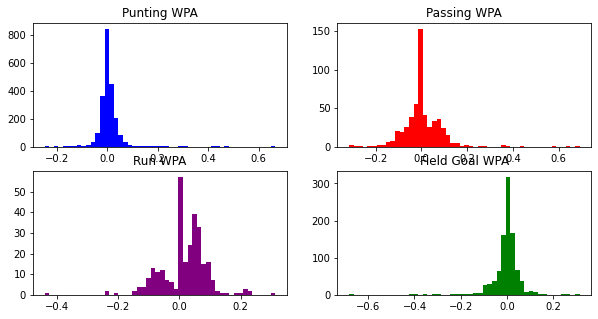

punt: mean: 0.0050487769070731 std: 0.04359692738336983
pass: mean: 0.006595747256606629 std: 0.09138724857629413
run: mean: 0.01592872150410966 std: 0.07852080425831684
fg: mean: -0.0013569526360666271 std: 0.062021206697173675


In [16]:
def showStats(dis, title):
    mean = dis.mean()
    std = dis.std()
    print(title +": mean: " + str(mean) + " std: " +str(std))



fig, axs = plt.subplots(2,2, figsize=(10,5))

punt_wpa = punt['avg_wpa']
axs[0,0].hist(punt_wpa,color='blue',bins=50)
axs[0,0].set_title('Punting WPA')

pass_wpa = passing['avg_wpa']
axs[0,1].hist(pass_wpa,color='red',bins=50)
axs[0,1].set_title('Passing WPA')

run_wpa = run['avg_wpa']
axs[1,0].hist(run_wpa,color='purple',bins=50)
axs[1,0].set_title('Run WPA')

fg_wpa = field_goal['avg_wpa']
axs[1,1].hist(fg_wpa,color='green',bins=50)
axs[1,1].set_title('Field Goal WPA')
plt.show()

showStats(punt_wpa, 'punt')
showStats(pass_wpa, 'pass')
showStats(run_wpa, 'run')
showStats(fg_wpa, 'fg')

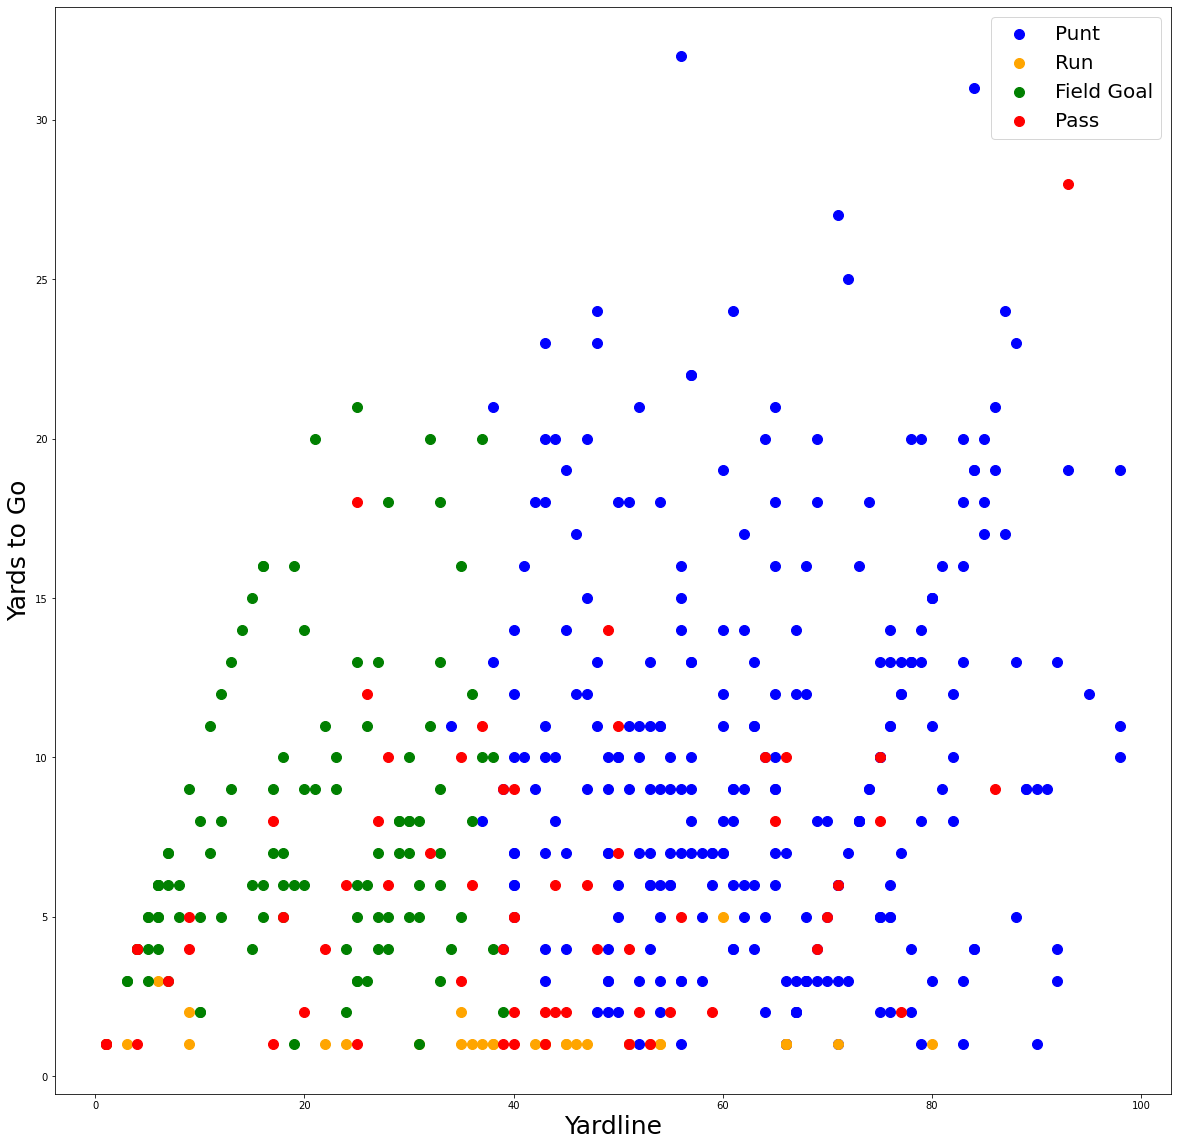

In [17]:
fig, axs = plt.subplots(1,1, figsize=(20,20))


sample = fourthdown.sample(500)

axs.scatter(x = sample[sample['play_type'] == 'punt']['yardline_100'], y = sample[sample['play_type'] == 'punt']['ydstogo'], s = 100,c='blue', label = 'Punt')
axs.scatter(x = sample[sample['play_type'] == 'run']['yardline_100'], y = sample[sample['play_type'] == 'run']['ydstogo'], s = 100,c='orange', label = 'Run')
axs.scatter(x = sample[sample['play_type'] == 'field_goal']['yardline_100'], y = sample[sample['play_type'] == 'field_goal']['ydstogo'], s = 100,c='green', label = 'Field Goal')
axs.scatter(x = sample[sample['play_type'] == 'pass']['yardline_100'], y = sample[sample['play_type'] == 'pass']['ydstogo'], s = 100,c='red', label = 'Pass')


axs.set_xlabel('Yardline', fontsize = 25)
axs.set_ylabel('Yards to Go', fontsize = 25)
axs.legend(prop={'size': 20})

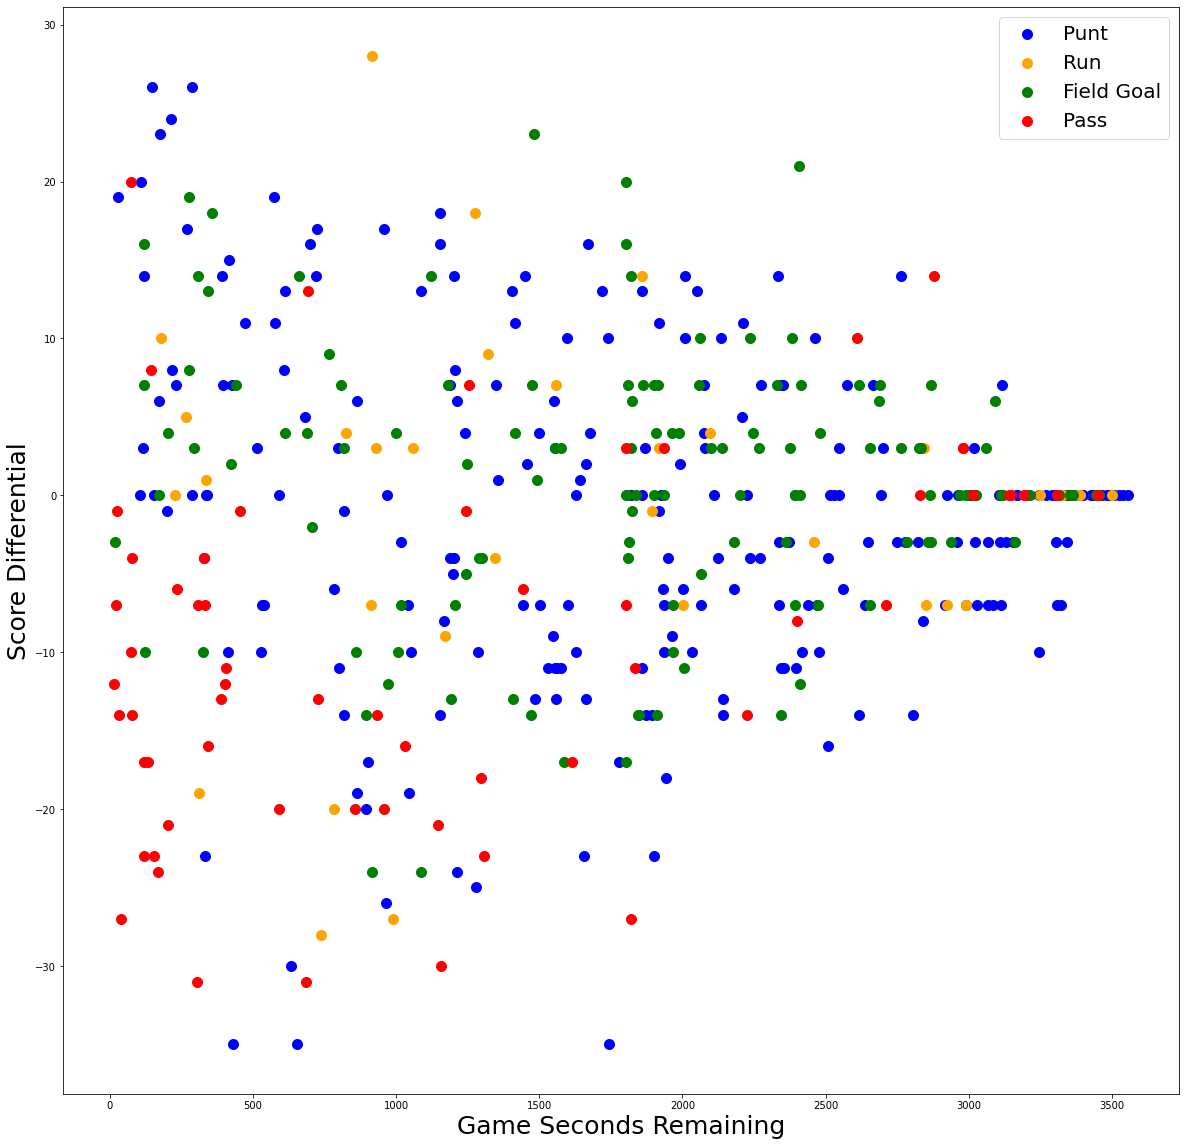

In [18]:
fig, axs = plt.subplots(1,1, figsize=(20,20))

sample = fourthdown.sample(500)

axs.scatter(x = sample[sample['play_type'] == 'punt']['game_seconds_remaining'], y = sample[sample['play_type'] == 'punt']['score_differential'], s = 100,c='blue', label = 'Punt')
axs.scatter(x = sample[sample['play_type'] == 'run']['game_seconds_remaining'], y = sample[sample['play_type'] == 'run']['score_differential'], s = 100,c='orange', label = 'Run')
axs.scatter(x = sample[sample['play_type'] == 'field_goal']['game_seconds_remaining'], y = sample[sample['play_type'] == 'field_goal']['score_differential'], s = 100,c='green', label = 'Field Goal')
axs.scatter(x = sample[sample['play_type'] == 'pass']['game_seconds_remaining'], y = sample[sample['play_type'] == 'pass']['score_differential'], s = 100,c='red', label = 'Pass')


axs.set_xlabel('Game Seconds Remaining', fontsize = 25)
axs.set_ylabel('Score Differential', fontsize = 25)
axs.legend(prop={'size': 20})

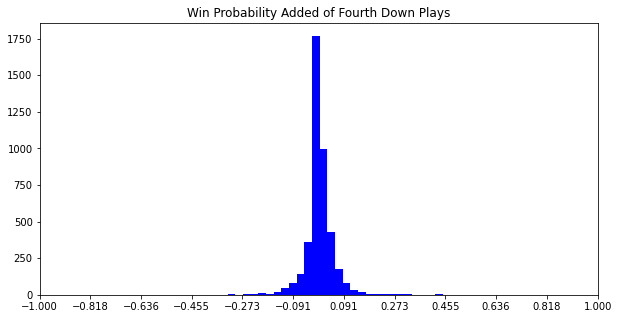

Quick Stats: 
Mean: 0.004495741365419993
Standard Deviation: 0.05860206221735863
Minimum: -0.6838559804395248
Maximum: 0.6920193582773209


In [38]:
# plays that are not punts or field goals 


fig, axs = plt.subplots(1,1, figsize=(10,5))
wpa = fourthdown['avg_wpa']
wpa_mean, wpa_std = wpa.mean(), wpa.std()
wpa_min, wpa_max = wpa.min(), wpa.max()
wpa_range = wpa_max - wpa_min
axs.hist(wpa,color='blue',bins=50)
axs.set_title('Win Probability Added of Fourth Down Plays')

x_ticks = np.linspace(-1,1,12)
axs.set_xticks(x_ticks)
plt.show()

print("Quick Stats: ")
print("Mean: " + str(wpa_mean))
print("Standard Deviation: " + str(wpa_std))
print("Minimum: " + str(wpa_min))
print("Maximum: " + str(wpa_max))




In [53]:
# brackets should be by standard deviation every 1/3 standard deviation
bracket = wpa_std
print(wpa.shape)
p = wpa[(wpa < 0.05) & (wpa > 0.025)]
print(p.shape)
print(bracket)
print(wpa_range / bracket)

# less than -0.2: 23


# greater than 0.2: 37
# .15 - .2: 24
# .1 - .15: 71 
# .75 - .1: 93 
# 0.05 - 0.075: 229
# 0.025 - 0.05



    

(4235,)
(488,)
0.05860206221735863
23.478275109391884


(array([  39.,   71.,   89.,  447., 1407., 1239.,  717.,   93.,   71.,
          62.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

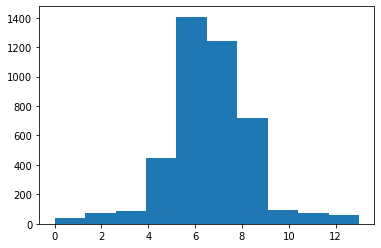

In [57]:

def discretizeData(data):
    discretizedData = np.empty(data.shape)
    for i,val in enumerate(data):
        if(val < -0.2):
            discretizedData[i] = 0
        elif(val >= -.2 and val < -.15):
            discretizedData[i]  = 1
        elif(val >= -.15 and val < -.1):
            discretizedData[i] = 2
        elif(val >= -.1 and val < -.075):
            discretizedData[i] = 3
        elif(val >= -.075 and val < -.05):
            discretizedData[i] = 4
        elif(val >= -.05 and val < -.025):
            discretizedData[i] = 5
        elif(val >= -.025 and val < 0):
            discretizedData[i] = 6
            
        elif(val >= 0 and val < 0.025):
            discretizedData[i] = 7
        elif(val >= 0.025 and val < 0.05):
            discretizedData[i] = 8
        elif(val >= 0.05 and val < 0.075):
            discretizedData[i] = 9
        elif(val >= 0.075 and val < 0.1):
            discretizedData[i] = 10
        elif(val >= 0.1 and val < 0.15):
            discretizedData[i] = 11 
        elif(val >= 0.15 and val < 0.2):
            discretizedData[i] = 12
        else: 
            discretizedData[i] = 13
    return discretizedData
data = wpa.to_numpy()
discretized_wpa = discretizeData(data)
plt.hist(discretized_wpa)



In [70]:
dataset = pd.read_csv('play_by_play_2021.csv')

important_titles = ["play_id",
                    "game_id", #Unique Game Id
                    "posteam", #Offence/Possetion Team
                    "result",
                    "posteam_type", #Offence Home/Away
                    "defteam", #Defence Team
                    "yardline_100", #Yards from Touchdown
                    "half_seconds_remaining",
                    "game_half",
                    "drive", #Number of Posetions
                    "down",
                    "goal_to_go", #is it 4th and goal? 0 if no, 1 if yes
                    "time",
                    "ydstogo", #yards till first down/touchdown
                    "desc", #description
                    "play_type",
                    "yards_gained", #0 if punted or field goal
                    "qb_kneel", #rare 4th down occurance but possible
                    "field_goal_result",
                    "kick_distance",
                    "posteam_timeouts_remaining",
                    "defteam_timeouts_remaining",
                    "total_home_score",
                    "total_away_score",
                    "posteam_score",
                    "defteam_score",
                    "score_differential",
                    "score_differential_post", #score differential after play happened
                    "no_score_prob",
                    "opp_fg_prob",
                    "opp_safety_prob",
                    "opp_td_prob",
                    "fg_prob",
                    "safety_prob",
                    "td_prob",
                    "wp", #winning percentage
                    "def_wp", 
                    "home_wp_post",
                    "away_wp_post",
                    "punt_blocked",
                    "third_down_converted",
                    "third_down_failed",
                    "fourth_down_converted",
                    "fourth_down_failed",
                    "punt_inside_twenty",
                    "punt_in_endzone",
                    "punt_out_of_bounds",
                    "punt_downed",
                    "punt_fair_catch",
                    "season", #2021 for now
                    "series_result",
                    "weather",
                    "nfl_api_id", #new data set-ish
                    "play_type_nfl",
                    "special_teams_play", #0 or 1
                    "drive_play_count",
                    "drive_time_of_possession",
                    "drive_first_downs",
                    "drive_inside20",
                    "drive_ended_with_score",
                    "roof",
                    "surface",
                    "wind" #no valuable info could add from weather
                   ]

baseline_titles = [
    "yardline_100",
    "game_seconds_remaining",
    "down",
    "ydstogo",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "wp",
    "def_wp"
    
    
    
    
]

dataset = dataset[dataset['down']==4][baseline_titles]


/Users/lucasderr/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [71]:
X = dataset.to_numpy()
y = discretized_wpa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [72]:
# Baseline Classifier for guessing the win probability added of a 4th down play
# Keep in mind: random guess: 1/14 = 0.07142857142

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

print("Training Score: " + str(clf.score(X_train, y_train)))
print("Testing Score: " + str(clf.score(X_test, y_test)))


Training Score: 0.999409681227863
Testing Score: 0.3400236127508855


# Problem Space 1 - Weighing Samples' relevance to the final outcome of the game (Lucas)

Idea: Samples that are most relevant are ones where the outcome of the game is not yet determined - 50/50 probability of winning

Idea: Samples that are most relevant are ones which create the biggest swing in win probability

use average wpa as the new label. Split it off into multiple sections. use a different model for each option. Run the model for each option. Choose the one with the best output.

# Problem Space 2 - Feature Engineering: Go through dataset and get keep all features which could potentially be useful. Also do some analysis on the features.

# Problem Space 3 - Train a Baseline Model and try to find ways to improve it